<a href="https://colab.research.google.com/github/invisilico/Tutorial-Notebooks/blob/main/Notebook_With_Outputs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to ***your*** Digital-Behaviour project!


---

Made by Nishant Jana with lots of inputs from Dr. May Harrington, Dr. Tany leise, Dr. Horacio de la Iglesia and Dr. Raymond Sanchez     

(inspired by the e-mail timestamps project by the de la Iglesia lab @ University of Washington, Seattle!)

(Visualization section heavily adapted from Dr. Leise's SRBR Chronoschool 2020 class)



---


Find me at:

Twitter: [@In_Visilico](https://twitter.com/In_Visilico) , Github: [@invisilico](https://github.com/invisilico) , E-mail: nishantjana5@gmail.com

Feel free to DM/raise an issue/E-mail for any help, feedback and suggestions!


---






---

# Helpful tips

Click the [![](https://user-images.githubusercontent.com/68754864/97426576-a8c14200-1939-11eb-9197-15c7be91ab96.png)] button on the left to each cell to run them. If they have inputs, be sure to fill them first!

Make sure you have the My Activity.html file from takeout.google.com ready to upload.

As long as possible try going ahead linearly rather than going back and forth across sections. Some of the variable names are shared for convenience and your output may keep changing because of it!
```
The steps to be followed are stylized like this and,

# your tasks following each step are marked with a hash!
```



---





---


# Reading the Data

Should you open the HTML file as text, you'll notice that all the data that makes up those panels in the browser version are actually a single (but very long) line of text. That is of no use to us in any way.

What we need here, is to build a DataFrame. A Dataframe is essentially a large table with columns with all the data we need, organised by entry number very similar to excel sheets, but only as big as required. A really important thing about a (pandas) DataFrame is that it allows you to selectively query it to obtain sections of the data that meet your criteria.

The DataFrame made here follows the structure below:


```
# dataframe structure (exemplar)

   App      of24h   Day Month Year  TimeZone Weekday TimeStamp
0  Appname  10.567  2   5     2020  GMT      1       [datetime.datetime(2020, 5, 2, 15, 35, 10)]
1  Appname  12.263  2   5     2020  GMT      1       [datetime.datetime(2020, 5, 2, 15, 35, 10)]
2  Appname  14.139  2   5     2020  GMT      1       [datetime.datetime(2020, 5, 2, 15, 35, 10)]
3  Appname  15.667  2   5     2020  GMT      1       [datetime.datetime(2020, 5, 2, 15, 35, 10)]
```


In [2]:
#@title ### Set-Up!

#@markdown Wait for colab to allocate system resources. Once done, click play on the next cell.

from google.colab import files
import os
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from calendar import monthrange
from calendar import isleap
from datetime import datetime
from dateutil.parser import parse
import matplotlib as mpl
import matplotlib.ticker as ticker


In [3]:
#@title sample data loader
#@markdown Do not use unless other options have been exhausted
!curl https://raw.githubusercontent.com/invisilico/DigitalRhythmsProject/master/Sample%20Datasets/nov3data.tar.gz --output MyActivity.tar.gz
!tar -xvf  'MyActivity.tar.gz'

os.rename(r'My Activity.html',r'actdata.txt')
with open('actdata.txt','r') as file:
  txt = file.readlines()
print("Data loaded from file.")
!rm *.* #removes file, bash shell command
print("File deleted from Colab, verify in files on left panel.")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  771k  100  771k    0     0  4041k      0 --:--:-- --:--:-- --:--:-- 4041k
My Activity.html
Data loaded from file.
File deleted from Colab, verify in files on left panel.


In [ ]:
#@title Load the Data from your File

#@markdown This cell will keep running till you select the file. Click the "Choose Files" tile as it appears to select file to upload from your system. The file will be deleted once data is loaded.
#@markdown 
#@markdown Ensure the file is called *exactly* 'My Activity.html'
file = files.upload()
#urename the file to use as text file, read lines method. avoids beautiful soup
os.rename(r'My Activity.html',r'actdata.txt')
with open('actdata.txt','r') as file:
  txt = file.readlines()
print("Data loaded from file.")
!rm *.* #removes file, bash shell command
print("File deleted from Colab, verify in files on left panel.")

In [4]:
#@title Build a Dataframe

#@markdown This cell makes a dataframe from your data from the file. Might take a while!
actdat = txt[32]

#find indices between which appname and timestamp exists
preapp = [app.end(0) for app in re.finditer('<p class="mdl-typography--title">', actdat)] 
postapp = [app.start(0) for app in re.finditer('<br></p></div><div class="content-cell mdl-cell mdl-cell--6-col mdl-typography--body-1">', actdat)]
posttime = [time.start(0) for time in re.finditer('</div><div class="content-cell mdl-cell mdl-cell--6-col mdl-typography--body-1 mdl-typography--text-right">', actdat)]

appname = []
datetime = []
timezone = []

dd = []
mm = []
yy = []
of24h = []
weekday = []

for i in range(len(posttime)):

  appname += [actdat[preapp[i]:postapp[i]]]
  
  # some (stupid) fix that somehow works but I don't remember why
  stamp = actdat[posttime[i]-30:posttime[i]]
  idx = [app.end(0) for app in re.finditer('>', stamp)]
  if len(idx) > 0:
    stamp = stamp[idx[-1]:]

  datetime += [parse(stamp[:-4])]
  dd += [int(datetime[-1].day)]
  mm += [int(datetime[-1].month)]
  yy += [int(datetime[-1].year)]  
  of24h +=   [np.round(int(datetime[-1].hour)+(int(datetime[-1].minute)/60), decimals = 3)]
  timezone += [stamp[-3:]]
  weekday += [int(datetime[-1].weekday())]

appname.reverse()
of24h.reverse()
dd.reverse()
mm.reverse()
yy.reverse()
timezone.reverse()
datetime.reverse()

data = pd.DataFrame(list(zip(appname,of24h,dd,mm,yy,timezone,weekday,datetime)),columns = ['App','of24h','Day','Month','Year','TimeZone','Weekday','TimeStamp'])

In [5]:
#@title Run to see few entries of the dataframe
data

,App,of24h,Day,Month,Year,TimeZone,Weekday,TimeStamp
0,Flipkart Online Shopping App,19.967,12,11,2016,IST,1,2016-11-12 19:58:19
1,Flipkart Online Shopping App,20.633,12,11,2016,IST,1,2016-11-12 20:38:43
2,com.samsung.networkui,19.067,28,9,2017,IST,1,2017-09-28 19:04:52
3,com.samsung.networkui,22.667,28,9,2017,IST,1,2017-09-28 22:40:31
4,Google Drive,18.267,6,10,2017,IST,1,2017-10-06 18:16:16
...,...,...,...,...,...,...,...,...
46087,Google Classroom,10.967,3,11,2020,IST,4,2020-11-03 10:58:14
46088,WhatsApp Messenger,10.967,3,11,2020,IST,3,2020-11-03 10:58:34
46089,Samsung One UI Home,10.983,3,11,2020,IST,3,2020-11-03 10:59:06
46090,Samsung Clock,11.000,3,11,2020,IST,5,2020-11-03 11:00:02


```
# Can you think of a better way to store the data? Do you see any issues with the current dataframe structure?
```


---





---


# What data do we have here?

Running the cell below produces a raster plot for a single month of your choice. A raster plot is used widely for neural spiking data or any sort of repetitive binary data across time. A tick represents an event and blank space shows absence of event. Accordingly, it also means that two events cannot simultaneously occur. (two apps can be opened in succession, but not at the same time). It is also called an event plot in the python matplotlib pyplot library.


```
Look at the plot below for any month of your choosing, and see what your data looks like.

Note that each vertical stripe (a tick) is the event of an app being opened.
```
---



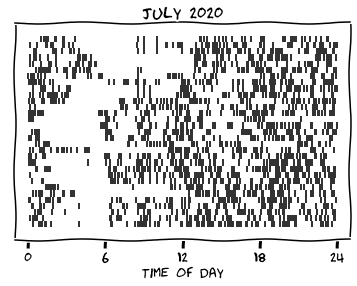

In [6]:
#@title Month Raster Plotter

Year =  2020 #@param {type:"number"}
Month = "July" #@param ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]


with_XKCD = True #@param {type:"boolean"}
 #@markdown I love the xkcd comics and their style being applied to my plots, but your professor may not. If you have to submit the output, I suggest you untick xkcd before doing so.

monthnames  = {"January":1, "February":2, "March":3, "April":4, "May":5, "June":6, "July":7, "August":8, "September":9 ,"October":10, "November":11, "December":12}

def mmprepdata(dataframe, ynum, mnum):
  
    frame = dataframe.query(('Year == '+str(ynum)+' and Month == '+str(mnum)))
    
    days = monthrange(ynum,mnum)[1]
    plotdata = np.empty(days, dtype = object)
    for d in range(days):
      daydata = frame.query(('Day == '+str(d+1)))
      plotdata[-d-1] = daydata.of24h.to_numpy()

    return plotdata

def mmraster(dataframe,year,month,xkcd):
  
  mnum = monthnames[Month]
  plotdata = mmprepdata(dataframe,year,mnum)

  if xkcd == True:

    with plt.xkcd():
      plt.eventplot(plotdata[:], color = "0.2")
      plt.xlabel("Time of Day")
      plt.title((str(month)+" "+str(year)))
      plt.xlim(-1,25)
      plt.yticks([])
      plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(6))
    
  else:

    plt.eventplot(plotdata[:], color = "0.2")
    plt.xlabel("Time of Day")
    plt.title((str(month)+" "+str(year)))
    plt.xlim(-1,25)
    plt.yticks([])
    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(6))

mmraster(data,Year,Month,with_XKCD)

```
#what do you see? Are there any any noticable patterns?
```


---





---


# Cleaning Data (and issues with data collection)
Okay first things first, Now that you've seen your data there are some background checks to be done. Take a good hard look at the plot(s).


```
> Are the ticks at the correct time?
> Is it sparse or too dense? 
> Is there data on the plot at all? 
> Is it only restricted to the left-half (first 12 hours of the plot)?
```


These issues shouldn't be there, and are generated by the way we source or read the data. No activity means your records don't exist (or my code did not work as intended). Sparse activity might be from low usage on your end or, your phone only partially logging data. Chunks of missing data when you know your phone was on could be caused by logging issues as well. These are all part of the data collection process, and generally, unless you can repeat the experiment, you just have to deal with the hand you're dealt. 


Dr. Leise faced a similar issue with data from [polar bears](https://journals.sagepub.com/doi/abs/10.1177/0748730419900877?journalCode=jbra), 
and of course you can't go and ask a polar bear to fill in some of the missing data.  
So she used innovative mathematical ways I barely understand to make cool inferences from the data nonetheless. 
[Read more here!](https://doi.org/10.1177/0748730417709105)

Some errors may also be caused directly by the way you read the data and can be fixed. 
If all your data is in the first 12 hours in the 24 hour day, or exists and shows a blank plot, 
I messed up big time, and you should let me know!

```
Let's just hope these issues did not occur with your data. 

Note: I've been seeing issues with my own takeouts, 
data from more than 1 year ago disappearing and so on. 
It's rather vague.

Update: The notebook now looks one year into the past from last full month specified
Missing Data (few days here and there) should not bother you on most part
```

---


There's one thing though. In this particular case, we want to look at *your* usage of the phone and yours alone. From the data I've seen so far, most phones only record events from when *you* opened an app. But some phones have these pesky little events marked at times when their users were asleep or busy.
```
So look again, at times of the day you're sure you were asleep or definitely not using your phone. 

If you see pesky ticks there:
>   Clean your data using the cells below!

If not:
>   Woohoo, skip ahead to Visualization!
```
Whichever path you take, take a minute to realise that this cleaning of the data will change your outcomes. For us, as we are interested in seeing *your* activity, this is noise, but to someone studying phone activity as a whole, this is vital information! 

What counts as noise and error is often determined by your question, and any such decisions that you make should be properly reported when you publish/share your work!


---




```
Steps to clean 

> Run the first cell to plot a month you remember clearly.
> Run the second cell to plot for a day where you think you see suspicious activity.
> Note the time window within which it was observed and enter that data in the next cell
> Look at the entries listed, and identify which apps are causing these issues
> COPY the appname into the next cell and run it to scrub every instance of it clean from the dataframe.
> Raster plot the month again and ensure your data is clean!

> If not, repeat above sequence till data is clean!
```
Apps like weather and some other regularly updating applications are more likely to be the culprit.

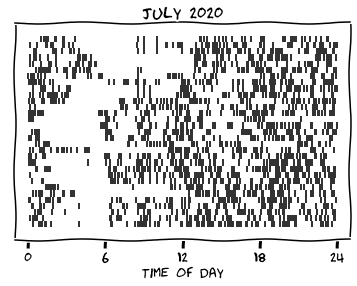

In [7]:
#@title Raster plot a month you remember well.

Year =  2020 #@param {type:"number"}
Month = "July" #@param ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
mnum = monthnames[Month]

with_XKCD = True #@param {type:"boolean"}
 #@markdown I love the xkcd comics and their style being applied to my plots, but your professor may not. If you have to submit the output, I suggest you untick xkcd before doing so.

monthnames  = {"January":1, "February":2, "March":3, "April":4, "May":5, "June":6, "July":7, "August":8, "September":9 ,"October":10, "November":11, "December":12}

def mmprepdata(dataframe, ynum, mnum):
  
    frame = dataframe.query(('Year == '+str(ynum)+' and Month == '+str(mnum)))
    
    days = monthrange(ynum,mnum)[1]
    plotdata = np.empty(days, dtype = object)
    for d in range(days):
      daydata = frame.query(('Day == '+str(d+1)))
      plotdata[-d-1] = daydata.of24h.to_numpy()

    return plotdata

def mmraster(dataframe,year,month,xkcd):
  
  mnum = monthnames[Month]
  plotdata = mmprepdata(dataframe,year,mnum)

  if xkcd == True:

    with plt.xkcd():
      plt.eventplot(plotdata[:], color = "0.2")
      plt.xlabel("Time of Day")
      plt.title((str(month)+" "+str(year)))
      plt.xlim(-1,25)
      plt.yticks([])
      plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(6))
    
  else:

    plt.eventplot(plotdata[:], color = "0.2")
    plt.xlabel("Time of Day")
    plt.title((str(month)+" "+str(year)))
    plt.xlim(-1,25)
    plt.yticks([])
    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(6))

mmraster(data,Year,Month,with_XKCD)

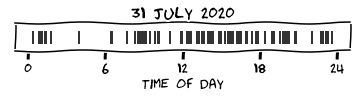

In [8]:
#@title Raster plot a single day with suspicious activity

#Year  =   2020#@param {type:"integer"}
#Month = "July" #@param ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
Day   =  31#@param {type:"integer"}
xkcd = True #@param {type:"boolean"}
monthnames  = {"January":1, "February":2, "March":3, "April":4, "May":5, "June":6, "July":7, "August":8, "September":9 ,"October":10, "November":11, "December":12}

def dayprepdata(dataframe, ynum, mnum,dnum):
  
    frame = dataframe.query(('Year == '+str(ynum)+' and Month == '+str(mnum)+' and Day == '+str(dnum)))
    plotdata = frame.of24h.to_numpy()
    
    return plotdata

def dayraster(dataframe,year,month,day,xkcd):
  
  mnum = monthnames[month]
  plotdata = dayprepdata(dataframe,year,mnum,day)

  if xkcd == True:

    with plt.xkcd():
      plt.eventplot(plotdata[:], color = "0.2")
      plt.xlabel("Time of Day")
      plt.title((str(day)+" "+str(month)+" "+str(year)))
      plt.xlim(-1,25)
      plt.yticks([])
      plt.gca().set_aspect(1)
      plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(6))

  else:

    plt.eventplot(plotdata[:], color = "0.2")
    plt.xlabel("Time of Day")
    plt.title((str(day)+" "+str(month)+" "+str(ynum)))
    plt.xlim(-1,25)
    plt.yticks([])
    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(6))

dayraster(data,Year,Month,Day,xkcd)

In [9]:
#@title Find the names of apps active in the odd hours you've selected

#@markdown (same date as previous cell)

start_time =  3#@param {type:"integer"}
end_time = 5 #@param {type:"integer"}

#@markdown Integers only! (time in hours, between 0 and 24)
oddtime  = data.query(('Year == '+str(Year)+' and Month == '+str(mnum)+' and Day == '+str(Day)+' and of24h >= '+str(start_time)+' and of24h <= '+str(end_time)))
Unique = oddtime.App.unique()
print("Supicious apps: ",Unique)

Supicious apps:  ['com.estrongs.android.pop.pro' 'Samsung One UI Home']


In [12]:
#@title Cleaning Dataframe

#@markdown Paste in one App name at a time and run to completely remove all instances of it from the dataframe.

Appname = "Samsung One UI Home" #@param {type:"string"}

if Appname != "":
  data = data.query(("App != "+'"'+str(Appname)+'"'))
  print("All instances of that app should be gone now!")
else:
  print("enter an appname!")

#@markdown Be careful with this cell. You cannot revert the changes caused. If you make a mistake, you must run the "Build a Dataframe" cell again and start over.
# Unique = data.App.unique()
# print(Unique)

All instances of that app should be gone now!


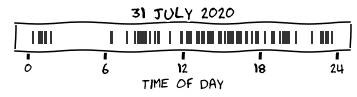

In [13]:
#@title Verify if the suspicious event was removed

#Year  =   2020#@param {type:"integer"}
#Month = "July" #@param ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
# Day   =  31#@param {type:"integer"}
xkcd = True #@param {type:"boolean"}
monthnames  = {"January":1, "February":2, "March":3, "April":4, "May":5, "June":6, "July":7, "August":8, "September":9 ,"October":10, "November":11, "December":12}

def dayprepdata(dataframe, ynum, mnum,dnum):
  
    frame = dataframe.query(('Year == '+str(ynum)+' and Month == '+str(mnum)+' and Day == '+str(dnum)))
    plotdata = frame.of24h.to_numpy()
    
    return plotdata

def dayraster(dataframe,year,month,day,xkcd):
  
  mnum = monthnames[month]
  plotdata = dayprepdata(dataframe,year,mnum,day)

  if xkcd == True:

    with plt.xkcd():
      plt.eventplot(plotdata[:], color = "0.2")
      plt.xlabel("Time of Day")
      plt.title((str(day)+" "+str(month)+" "+str(year)))
      plt.xlim(-1,25)
      plt.yticks([])
      plt.gca().set_aspect(1)
      plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(6))

  else:

    plt.eventplot(plotdata[:], color = "0.2")
    plt.xlabel("Time of Day")
    plt.title((str(day)+" "+str(month)+" "+str(ynum)))
    plt.xlim(-1,25)
    plt.yticks([])
    plt.gca().set_aspect(1)
    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(6))

dayraster(data,Year,Month,Day,xkcd)



```
Done cleaning? Continue to Visualization!
```


---






---

# Visualization!


Obtaining and cleaning data is only the beginning. The real fun starts with making sense of the data. 

However, reading each entry does us no good. Here comes the power of visualization!

> Note: If your plots are too small and blurry, scroll down to the end and there's a figure resolution controller cell.

```
Run the following cells to generate a few visuals from your data. 

Each visual tells a different story and aims to communicate a different facet of your data.

# See what they have to say about you! Note it down!
```

This is by no means an exhaustive list of possible visualisation but only a few commonly used ones that seem to work with this sort of data. 

If you're feeling adventurous, try some other ones you know of! Share them with me so I can add them too!


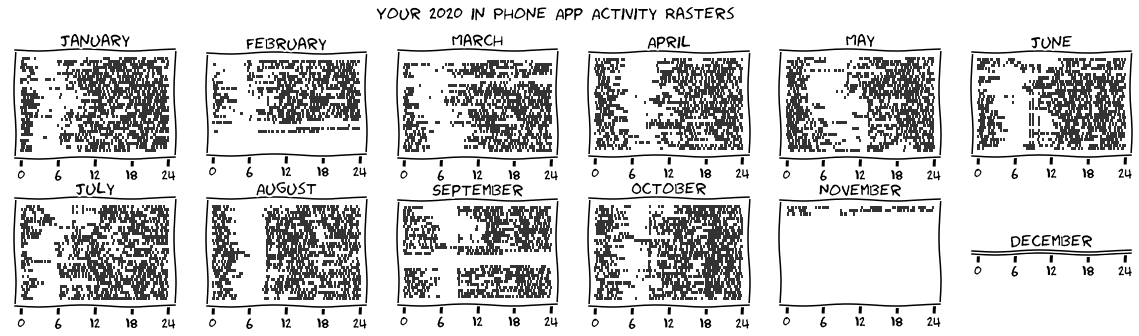

In [14]:
#@title Of course, you could just start by generating raster plots for the whole year. Run this to see *your* year! (so far)

year = 2020 #@param {type:"number"}

xkcd = True #@param {type:"boolean"}
rasterdata = {}

monthnames  = {"January":1, "February":2, "March":3, "April":4, "May":5, "June":6, "July":7, "August":8, "September":9 ,"October":10, "November":11, "December":12}

def mmprepdata(dataframe, ynum, mnum):
  
    frame = dataframe.query(('Year == '+str(ynum)+' and Month == '+str(mnum)))
    
    days = monthrange(ynum,mnum)[1]
    plotdata = np.empty(days, dtype = object)
    for d in range(days):
      daydata = frame.query(('Day == '+str(d+1)))
      plotdata[-d-1] = daydata.of24h.to_numpy()

    return plotdata

for month in monthnames.keys():
  mnum = monthnames[month]
  rasterdata[month] = mmprepdata(data,year,mnum)

if xkcd == True:
  with plt.xkcd():
    yrrast, plots = plt.subplots(2, 6)
    yrrast.suptitle(('Your '+str(year)+' in Phone App Activity Rasters'))
    plt.gcf().set_size_inches(20,5)
    for i in range(2):
      for j in range(6):
        plots[i,j].eventplot(rasterdata[list(monthnames.keys())[(i*6)+j]], color = '0.2')
        plots[i,j].set_title((list(monthnames.keys())[(i*6)+j]))
        plots[i,j].set_xlim(-1,25)
        plots[i,j].set_yticks([])
        plots[i,j].xaxis.set_major_locator(ticker.MultipleLocator(6))
        plots[i,j].set_aspect(0.5)
else:

      yrrast, plots = plt.subplots(2, 6)
      yrrast.suptitle(('Your '+str(year)+' in Phone App Activity Rasters'))
      plt.gcf().set_size_inches(20,5)
      for i in range(2):
        for j in range(6):
          plots[i,j].eventplot(rasterdata[list(monthnames.keys())[(i*6)+j]], color = '0.2')
          plots[i,j].set_title((list(monthnames.keys())[(i*6)+j]))
          plots[i,j].set_xlim(-1,25)
          plots[i,j].set_yticks([])
          plots[i,j].xaxis.set_major_locator(ticker.MultipleLocator(6))
          plots[i,j].set_aspect(0.5)



```
There's lots to see here for the trained eye! 
# Do you see any patterns? 
# Months where you were more regular? (Onset of Activity was around the same time?)
# Months when offset of activity was regular?
# Are you rhythmic or arrhythmic?
# Do you see times when you got a little delayed or earlier each day? (You may have been freerunning!)
# Are there changes across seasons/academic schedules?

```
rasters are a great way of seeing the entirety of the data, but it is often hard to note everything from it. 




/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)


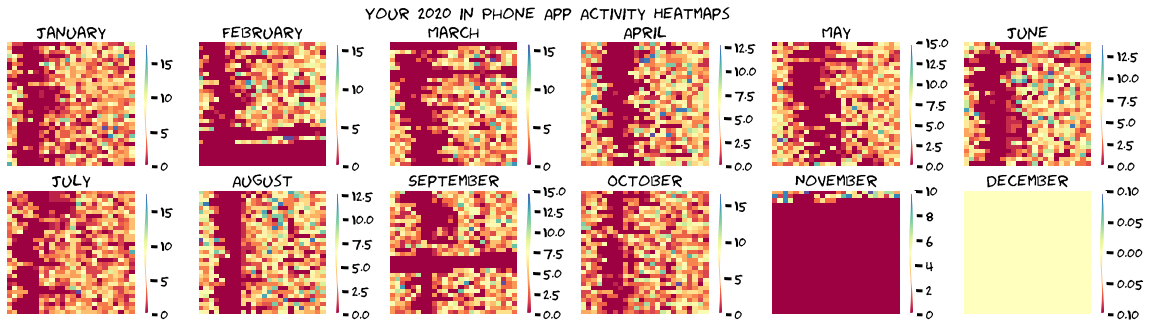

In [15]:
#@title Heatmaps!
year = 2020 #@param {type:"number"}

xkcd = True #@param {type:"boolean"}

hmdata = {}

for month in rasterdata.keys():
  mdata = rasterdata[str(month)]
  hmdata[str(month)] = np.empty((mdata.shape[0],24))
  for i in range(mdata.shape[0]):
    for j in range(24):
      hmdata[str(month)][-i-1,j] = np.sum(mdata[i]<j+1)-np.sum(mdata[i]<j)


if xkcd == True:
  with plt.xkcd():
    yrrast, plots = plt.subplots(2, 6)
    yrrast.suptitle(('Your '+str(year)+' in Phone App Activity Heatmaps'))
    plt.gcf().set_size_inches(20,5)
    for i in range(2):
      for j in range(6):
         sns.heatmap(hmdata[list(monthnames.keys())[(i*6)+j]],cmap="Spectral",xticklabels=False,yticklabels=False,ax=plots[i,j])
         plots[i,j].set_title((list(monthnames.keys())[(i*6)+j]))

else:
  yrrast, plots = plt.subplots(2, 6)
  yrrast.suptitle(('Your '+str(year)+' in Phone App Activity'))
  plt.gcf().set_size_inches(20,5)
  for i in range(2):
    for j in range(6):
      sns.heatmap(hmdata[list(monthnames.keys())[(i*6)+j]],cmap="Spectral",xticklabels=False,yticklabels=False,ax=plots[i,j])
      plots[i,j].set_title((list(monthnames.keys())[(i*6)+j]))


```
Heatmaps are great at showing changes in activity level over time.
They are not as specific in their representation, for example, this plot is binned hour wise.

# What do you see in this plot that is more clear than in rasters?
# What aspect of the rasters were lost in these plots?
```

In [ ]:
#@title Actogram (Double plotted!) #To be done

In [ ]:
#@title Average counts by day of week! #To be done

In [ ]:
#@title Circular Heatmaps! #To be done

```
# what did you see in these plots?
# When averaged across days, was there a trend emerging? 
# Are there certain hours you're always away from your phone?
# Do you think it might be a good proxy for your sleep time?
```


---





---

# Predicting sleep!

Phone app activity may not be a good proxy for sleep for *everyone*. However, I know for certain that I check my phone before I go to sleep, the moment I wake up and at times when I wake up in middle the night, I definitely go through my notifications. It's clearly evident in my data. 
It stands to reason that if I haven't checked my phone in a while, I'm probably asleep. 

This may not hold true for you at all, but we're going to try making a reasonable estimate, and you can be the judge of how well it fits for you!

To accurately predict sleep from the data, we could consider LOTS of factors. Maybe we should only consider night sleep (between hours 10PM and 10AM). Maybe we should consider local sunrise, wake up times, etc.

>*They're all reasonable means of estimating sleep.*
>
>BUT let's consider a different approach here.
>
>Let's assume that humans have two states: awake and asleep. 

They're mutually exclusive events and both are required, although the time devoted to each state may be different. Most humans sleep only about 8 hours a day and are awake the rest.

> We are limited by the data we have: Events of apps being opened.

From this data, we need a general method to predict this sleep phase and an awake phase. and remember, to complicate matters further, an app being opened does not necessarily mean you're fully awake (shutting off an alarm, cutting a call, etc.) *and* **not** opening an app does not mean you are asleep (just away from your phone or even using a single app on your phone for a long time!)

```
SO here's what we *can* do. 

> We take tiny steps through time.
> We can assume the baseline state is sleep.
> We collect evidence towards the fact that we're no longer sleeping (apps being opened)
> When we have sufficient evidence, we make the jump and say we're asleep
> When we encounter a time when the evidence is no longer sufficient, we return to the baseline (sleep)
```
This method of modelling a system where we assume unobservable (*hidden*) states that affect the output that we are collecting, are called Hidden Markov Models (HMMs).[Learn more here!](https://youtu.be/ceQXN0OUaFo)

However, this is not remotely a complete exploration of the model, but is only loosely used here to predict which of the two latent states are being observed from the data. I'm not an expert on the topic and was rather recently introduced to it myself, and I may be innacurate trying to explain it, so go online or talk to your professor to know more!

>I'll try explaining the method I'm using here though:

Let's look at just a day's worth of data. 

![image](https://user-images.githubusercontent.com/68754864/98016738-5b0a7500-1e24-11eb-85df-425df1f8537d.png)

This is my 31st of July, 2020. I know I was asleep between 3AM and 8AM.

> So what do we want to ensure? 

* The apps being opened around 6AM are probably alarms I did not wake up to. 

* There are gaps at other times of the day are not sleep. 

This gives us two parameters:

1. threshold number of events which infer "awake" (n_awake) (integers)
2. Delay period between inactivity and sleep. (delay) (in hours, float)

and a third hidden one that we need:

3. (Hidden) Threshold of awake probability (threshold, p_awake, float)



So here's what the code does:
```
> It goes through the 24 hours in increments of 0.001 (3.6 seconds). 
> It has a internal probability for awake (p_awake), which changes based on evidence.
> When it encounters an app being opened, it increases p_awake by (1/n).
> When p_awake is > 0, it slowly brings it down to 0 over the delay phase.
> For each time step it throws out either 1 (awake) or 0 (asleep, baseline).
> Awake is determined only if p_awake is greater than set threshold.
```
The threhold is required as n_awake app opening events will not occur together(they are discrete events) therefore a value of 1 will never be achieved, that would be an issue since multiple apps opened within a period of time should most definitely account for "awake". 

It would be ideal to have some sort of ground truth sleep data to compare it with but since we're sticking to just the data here, we'll only try fine tuning to a point we feel it is reasonable rather than comparing to the ground truth.

```
Steps:

> Pick a day from a month that you remember fairly well, and can tell when you might have been sleeping.
> Fine tune the parameters to improve the prediction till it roughly matches your estimate.
> Run the next cell to see how these parameters hold against a whole year of data.
```





In [ ]:
#@title Define variables
#@markdown Number of events required to infer wake state:
n_awake = 3 #@param {type:"slider", min:1, max:10, step:1}
#@markdown Amount of time delay to return for 1 app
delay = 0.25 #@param {type:"slider", min:0, max:1, step:0.05}
#@markdown Threhold to infer awake state from p_awake
threshold = 0.8 #@param {type:"slider", min:0, max:1, step:0.1}

In [ ]:
#@title Predicting Sleep! (for a day)

Year  =   2020#@param {type:"integer"}
Month = "July" #@param ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
Day   =  31#@param {type:"integer"}
xkcd = True #@param {type:"boolean"}
monthnames  = {"January":1, "February":2, "March":3, "April":4, "May":5, "June":6, "July":7, "August":8, "September":9 ,"October":10, "November":11, "December":12}



def dayprepdata(dataframe, ynum, mnum,dnum):
  
    frame = dataframe.query(('Year == '+str(ynum)+' and Month == '+str(mnum)+' and Day == '+str(dnum)))
    plotdata = frame.of24h.to_numpy()
    
    return plotdata

def dayraster(dataframe,year,month,day,xkcd):
  
  mnum = monthnames[month]
  plotdata = dayprepdata(dataframe,year,mnum,day)

  if xkcd == True:

    with plt.xkcd():
      plt.eventplot(plotdata[:], color = "0.2")
      plt.xlabel("Time of Day")
      plt.title((str(day)+" "+str(month)+" "+str(year)))
      plt.xlim(-1,25)
      plt.yticks([])
      plt.gca().set_aspect(1)
      plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(6))

  else:

    plt.eventplot(plotdata[:], color = "0.2")
    plt.xlabel("Time of Day")
    plt.title((str(day)+" "+str(month)+" "+str(ynum)))
    plt.xlim(-1,25)
    plt.yticks([])
    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(6))

dayraster(data,Year,Month,Day,xkcd)

In [ ]:
#@title predicting sleep! (for a month)
#@markdown pick a specific month and fine tune it!
Year =  2020 #@param {type:"number"}
Month = "July" #@param ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
mnum = monthnames[Month]

with_XKCD = True #@param {type:"boolean"}

monthnames  = {"January":1, "February":2, "March":3, "April":4, "May":5, "June":6, "July":7, "August":8, "September":9 ,"October":10, "November":11, "December":12}

def mmprepdata(dataframe, ynum, mnum):
  
    frame = dataframe.query(('Year == '+str(ynum)+' and Month == '+str(mnum)))
    
    days = monthrange(ynum,mnum)[1]
    plotdata = np.empty(days, dtype = object)
    for d in range(days):
      daydata = frame.query(('Day == '+str(d+1)))
      plotdata[-d-1] = daydata.of24h.to_numpy()

    return plotdata

def mmraster(dataframe,year,month,xkcd):
  
  mnum = monthnames[Month]
  plotdata = mmprepdata(dataframe,year,mnum)

  if xkcd == True:

    with plt.xkcd():
      plt.eventplot(plotdata[:], color = "0.2")
      plt.xlabel("Time of Day")
      plt.title((str(month)+" "+str(year)))
      plt.xlim(-1,25)
      plt.yticks([])
      plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(6))
    
  else:

    plt.eventplot(plotdata[:], color = "0.2")
    plt.xlabel("Time of Day")
    plt.title((str(month)+" "+str(year)))
    plt.xlim(-1,25)
    plt.yticks([])
    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(6))

mmraster(data,Year,Month,with_XKCD)



---

# Relation between weekday sleep loss and weekend excess sleep





In [ ]:
#@title weekday-weekend relation # to be done

In [ ]:
#@title does this hold? validation of model # to be done



---

# End of the line!

Take a print! Download your results!




In [ ]:
#@title figure resolution controller

plot_dpi = 80 #@param {type:"integer"}
#@markdown Set the above value to control how big the plots are. It will vary for each screen

#@markdown Setting it to higher values may make plots very large on screen but are ideal for downloading it and using it elsewhere. A minimum of 300dpi is ideal for print, I prefer 600dpi.
mpl.rcParams['figure.dpi'] = plot_dpi



---

# Please consider sharing your data with us! 



In [ ]:
#@title Privacy Filter ???
#@markdown Removes app names for privacy when sharing data. All apps are renamed to "app" with exception of clock/alarm apps which are renamed to "clock"

dataframe.loc[dataframe['App'].str.contains('clock', case=False), 'App'] = 'clock'
dataframe.loc[dataframe['App'] != "clock", "App"] = "app"

print("appnames have been removed, replaced with "+str(dataframe.App.unique())+"\n\n")
print(dataframe.head())



---

# Clean Slate!





In [ ]:
#@markdown Deletes all files from colab for privacy.
#@markdown
#@markdown (Make sure to only run this **after** you've saved everything you need!)
!rm *.*
print("Done and Dusted!")



---

